Trajectory generation based on a diffusion model.

Author: Harej Alexander Gabriel
Personal code: 10938956
alexandergabriel.harej@polimi.it

The scope of this assignment is to solve the FrozenLake environment from the OpenAI Gymnasium library using a diffusion model. Typically, diffusion models generate random images by starting from noise and progressively removing it, step-by-step, until the desired image is obtained. In this specific case, the diffusion model is applied to trajectory generation, producing paths that navigate a given map of obstacles; in this scenario, the holes on a frozen lake.

In [83]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

First, the training dataset needs to be generated. Using the Q-learning algorithm, a dataset consisting of 10,000 maps was created. Due to the considerable time required for this task, the dataset has been directly uploaded. The dataset consists of two distinct map sets: one representing the lake environment, and the other indicating optimal trajectories computed by the Q-learning algorithm.

The map of holes in the lake environment is represented by an map_size x map_size grid (in this assigment map_size = 10), where each cell is assigned either a value of 1 (indicating a hole) or 0 (indicating a frozen cell). These maps will be provided as input to the diffusion model as grids composed of zeros and ones.

The trajectories used for training are represented similarly: each cell of the grid is assigned a value of 0 or 1. A cell with a value of 1 means that it belongs to the optimal path for the corresponding map, while a cell with a value of 0 indicates that it does not belong to the designed trajectory. The diffusion model will output sampled trajectories in the same format—as grids of cells. We can interpret the value of each output cell (lying between 0 and 1) as the probability of belonging to the sampled trajectory.

Thus, the diffusion model is structured to take the lake map as input and produce a trajectory to reach the goal. Once the trajectory is identified, it becomes straightforward to implement a controller that ensures the agent adheres to this predicted path. The approach adopted here was inspired by the methodology described in [2], which addresses a similar challenge. In [2], trajectories are generated for autonomous vehicles within a domestic environment, with obstacle maps created using a Lidar sensor combined with a convolutional neural network (CNN) trained to identify obstacles. For simplicity, the initial position and goal location remain constant across all dataset samples.

Therefore, this problem is approached differently compared to traditional reinforcement learning (RL). Rather than learning specific actions to maximize a reward, the diffusion model directly samples a viable trajectory given an obstacle map. Although this approach necessitates a separate downstream controller, it provides rapid trajectory computation, unlike traditional RL methods that require retraining for each new environment.

The following piece of code loads and converts the trajectories into tensors, followed by an illustrative plot. The plots practically demonstrate the input provided to the diffusion model and one possible sampled output. The dataset, structured with zeros and ones as described, includes the trajectory set (x) and obstacle maps (cond). The obstacle maps are termed cond because they serve as conditioning data for trajectory sampling.

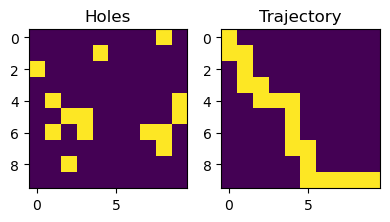

In [85]:
DTYPE = torch.float32
 # DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

def to_tensor(x,device):
    return torch.tensor(x, dtype=DTYPE).to(device)

## Uplaoding saved trajectories
x, cond =  np.load("training_tuple_10.npy")
## Splitting in batches
from torch.utils.data import DataLoader, TensorDataset
# Convert to PyTorch dataset
dataset = TensorDataset(to_tensor(x, DEVICE),to_tensor(cond, DEVICE))
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

idx = np.random.randint(len(x[:,0,0,0]))

fig, axes = plt.subplots(1, 2, figsize = (4,4))
axes[0].imshow(cond[idx,0,:,:])
axes[0].set_title('Holes')
axes[1].imshow(x[idx,0,:,:])
axes[1].set_title('Trajectory')
plt.tight_layout()
plt.show()

The diffusion model employed in this project is based on a UNet architecture, chosen due to its effectiveness in various diffusion-based studies. Score matching is used as the training method, requiring explicit embedding of both temporal and spatial conditions into the UNet model. The temporal embedding is realized through sinusoidal functions, while the obstacle map is processed through a CNN to capture essential spatial features. 

The secondary neural network implemented for this task is referred to as 'TwoBranchNet' in the code due to its dual-branch structure—one branch dedicated to processing temporal information and the other to spatial obstacle maps. Something similar is done in the studies [1] and [2], which address similar problems involving external environmental embedding. For embedding the obstacle maps specifically, the MLP incorporates a CNN as its initial stage, directly processing input maps marked by 0s for frozen lake cells and 1s for holes. CNN outputs are subsequently transformed into a vector and concatenated with the time embedding vector. The resulting vector is fed into a multilayer perceptron (MLP). The output from this MLP is then projected onto the various layers of the UNet, effectively conditioning the neural network to generate obstacle-aware trajectories.

Initially, the designed UNet, complemented by an MLP for embedding conditions, was validated using the MNIST dataset, comprising 60,000 labeled images of handwritten digits ranging from 0 to 9, each image being 28 x 28 pixels. The proposed UNet performed quite well, demonstrating high accuracy in generating digits based on labels.

After experimenting with various activation functions, ReLU was selected as it yielded the best results.

In [89]:
# Sinusoidal positional embedding for the time variable.
act_fcn = nn.ReLU()

class SinusoidalTimeEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        # t is assumed to be of shape [batch_size]
        device = t.device
        half_dim = self.embedding_dim // 2
        emb_scale = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_scale)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)   #[batch_size, 1, embedding_dim]
        return emb.squeeze(1)


class TwoBranchNet(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        """
        Neural net having two input branches for encodding the:
            - time step-> FNN
            - map of the holes -> CNN
        Args:
            hidden_dim: Number of hidden units in each branch.
            output_dim: Size of the final output vector (N) -> n_chanels of each conv_block
        """
        super().__init__()
        
        self.hidden_dim = hidden_dim

        self.branch1= SinusoidalTimeEmbeddings(hidden_dim)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1),  # (batch, 16, N/2, N/2)
            act_fcn,
            nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1), # (batch, 32, N/4, N/4)
            nn.Flatten(),
        )

        # Compute the flattened dimension after convolutions
        conv_output_size = map_size * map_size * 4

        # Merging network: Combines outputs from both branches.
        self.merged = nn.Sequential(
            nn.Linear(hidden_dim + conv_output_size, hidden_dim),
            act_fcn,
            nn.Linear(hidden_dim, hidden_dim),
            act_fcn,
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x1, x2):
        """
        Args:
            x1: Tensor of shape [batch, 1] -> time_step
            x2: Tensor of shape [batch, 1] -> condition
        Returns:
            Tensor of shape [batch, output_dim]
        """
        # Process each branch separately.
        out1 = self.branch1(x1)  # [batch, hidden_dim]
        out2 = self.encoder(x2)

        # # Concatenate along the feature dimension.
        merged = torch.cat([out1, out2], dim=1)  # [batch, hidden_dim*2]
        output = self.merged(merged)  # [batch, output_dim] #output_dim = channels
        return output
        # return self.branch3(out1)


# A simple convolutional block that performs a 3x3 convolution and adds a time- and condition-conditioned bias.
class ConvBlock(nn.Module):
    def __init__(self, in_channels,out_channels):
        super().__init__()
        # self.double_conv = double_conv(in_channels, out_channels)
        self.conv_layer1 = nn.Conv2d(in_channels,out_channels, 3, padding=1)
        self.conv_layer2 = nn.Conv2d(out_channels,out_channels, 3, padding=1)
        self.norm_layer = nn.BatchNorm2d(out_channels)
        self.act_fcn = act_fcn
        self.emb_projection = TwoBranchNet(128, out_channels)
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, time_step, condition):
        h = self.conv_layer1(x)
        emb_proj = self.emb_projection(time_step,condition).unsqueeze(-1).unsqueeze(-1) # unsqueeze needs to transform it the correct duimension
        h = h + emb_proj
        h = self.act_fcn(h)
        h = self.conv_layer2(h)
        h = self.act_fcn(h) + self.res_conv(x) # This is very important
        return h


# A simple convolutional network that embeds both time and a continuous condition.
class UNet(nn.Module):
    def __init__(self, in_chan=1, out_channels=1, base_ch = 64):
        """
        U net without skip connections 
        Args:
            in_channels: Number of channels in the input (1 for grayscale, 3 for rgb)
            in_channels: Number of channels in the output (1 for grayscale, 3 for rgb)
        """
        super().__init__()
        self.input_conv = nn.Conv2d(1, base_ch, kernel_size=3, padding=1)
        self.down1 = ConvBlock(in_channels=base_ch, out_channels=2*base_ch)
        self.down2 = ConvBlock(in_channels=2*base_ch, out_channels=4*base_ch)
        self.down3 = ConvBlock(in_channels=4*base_ch, out_channels=8*base_ch)
        self.mid = ConvBlock(in_channels=8*base_ch, out_channels=8*base_ch)
        self.up3 = ConvBlock(in_channels=16*base_ch, out_channels=4*base_ch) # 16 is the sum of mid layer and 3rd layer skip connection channels
        self.up2 = ConvBlock(in_channels=8*base_ch, out_channels=2*base_ch) # 8 is the sum of 3rd layer and 2nd layer skip connection channels
        self.up1 = ConvBlock(in_channels=4*base_ch, out_channels= base_ch)
        
        self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
        self.downsampling = nn.MaxPool2d(kernel_size=2)
        
        self.output_conv = nn.Conv2d(base_ch, out_channels, kernel_size=3, padding=1)

    def forward(self, x, t, condition):
        """
        Args:
            x: Input noise tensor of shape [batch, in_channels, height, width].
            t: Tensor of time steps of shape [batch].
            condition: Tensor of continuous condition values with shape [batch, condition_dim].
        """

        x0 = self.input_conv(x)
        x1_skip= self.down1(x0, t, condition)
        x1 = self.downsampling(x1_skip) # This is very important: downsampling after saving the skip connection
        x2_skip = self.down2(x1, t, condition)
        x2 = self.downsampling(x2_skip)
        x3 = self.down3(x2, t, condition)
        x_mid= self.mid(x3, t, condition)
        x_mid = torch.cat((x_mid,x3),axis=1)
        x2 = self.up3(x_mid, t, condition)
        x2 = self.upsampling(x2)
        if x2.shape[2:] != x2_skip.shape[2:]: ## In case the two concatenating arrays do not share the same dimensions
            x2 = F.interpolate(x2, size=x2_skip.shape[2:], mode="bilinear", align_corners=False)
        x2 = torch.cat((x2,x2_skip),axis=1)
        x1 = self.up2(x2, t, condition) 
        x1 = self.upsampling(x1)
        if x1.shape[2:] != x1_skip.shape[2:]: # x1 plays the role of the skip array
            x1 = F.interpolate(x1, size=x1_skip.shape[2:], mode="bilinear", align_corners=False)
        x1 = torch.cat((x1,x1_skip),axis=1)
        x0 = self.up1(x1, t, condition)
        x_out = self.output_conv(x0)
        
        return x_out

During training, artificial noise is incrementally added to the original data across multiple diffusion steps, aiming to achieve complete randomness at the final time step (t = T). The neural network attempts to predict this added noise, and by removing it, reconstructs the original data. The optimization loss function is calculated as the mean squared error (MSE) between the noise predicted by the model and the actual noise introduced. Additionally, in this case, the diffusion model explicitly conditions on the obstacle maps, enabling it, once trained, to accurately generate trajectories navigating around the provided obstacles.

In [100]:
# Score matching technique to compute the diffusion loss
def diffusion_loss(model, x0, t, condition):
    """Computes the score-matching loss for diffusion training"""
    noise = torch.randn_like(x0).to(DEVICE)
    b_size = len(noise[:,0,0,0])
    alpha_bar_t = alpha_bar[t.long()].view(batch_size, 1, 1, 1) #Transform the variable in teh opportune shape
    xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
    noise_pred = model(xt, t, condition)
    loss = torch.mean((noise - noise_pred) ** 2)
    return loss

The sampling of new trajectories is performed by reversing the training process; during training, the diffusion model learns to progressively corrupt the original 'image' until complete noise is achieved. By reversing this process, new trajectories can be generated, starting from noise and conditioned on the provided map of obstacles.

In [103]:
def sample(model, T, holes, device):
    """
    Generate an image by running the reverse diffusion process.
    """
    holes = to_tensor(holes,DEVICE)
    if holes.ndim == 2:
        holes = holes.view(1,1, map_size, map_size)

    x_t = torch.randn_like(holes).to(DEVICE)
    b = len(holes[:,0,0,0]) # batch size

    frames = []

    for t in reversed(range(T)):  # Reverse diffusion loop
    
        t_tensor = torch.tensor(np.ones((b,1))*t, dtype=DTYPE).to(device)
        
        if t == 0:
            noise = torch.tensor(np.array([0])).to(device) # shift term
        else:
            noise = torch.randn_like(x_t).to(device)
        # Predict the noise
        noise_pred = model(x_t, t_tensor, holes)
        # Compute x_{t-1} using the reverse equation
        alpha_t = alpha[t].view(1, 1, 1, 1).to(device)
        beta_t = beta[t].view(1, 1, 1, 1).to(device)
        alpha_bar_t = alpha_bar[t].view(1, 1, 1, 1) #Transform the variable in teh opportune shape
        sigma_t = torch.sqrt(beta_t)
        
        x_t = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t) / torch.sqrt(1-alpha_bar_t) * noise_pred) + sigma_t * noise

        if t % 10 == 0 or t == (T-1):
            frames.append(x_t.cpu().detach().numpy()[0,0,:,:])

    return x_t, frames


Setting the necessary parameters, specifically:

- num_epochs: Number of epochs for training the diffusion model.
- T: Number of diffusion steps used in the diffusion process.
- beta: Noise schedule determining the amount of noise added at each diffusion step. A linear schedule ranging from beta_min to beta_max is employed.

In particular, T represents a trade-off between accuracy and computational complexity: higher values of T improve the quality of the sampled 'image' but increase the sampling time. 

In [106]:
## Parameters
num_epochs = 400  # Increase for better results
T = 100 # Number of diffusion steps
beta_min, beta_max = 1e-4, 0.02  # Linear schedule range
map_size = 10
history_loss = []; best_loss = 1e9

# set seed
seed = 200
torch.manual_seed(seed)

# Linear noise schedule
beta = torch.linspace(beta_min, beta_max, T).to(DEVICE)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(DEVICE)  # Compute cumulative product \bar{\alpha}_t

I am attaching a trained model, which was trained using the provided dataset for 400 epochs on an Nvidia GTX 4070 Super GPU. The training took approximately 2.5 hours. To use the attached pretrained model, keep the variables new_model and training set to False. If you'd like to generate a new UNet model and train it from scratch, set both variables to True.

In [109]:
new_model = False
training = False

if new_model:
    model = UNet().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
else: 
    model = torch.load('Unet_model.pth',weights_only=False).to(DEVICE)

In [111]:
if training:

    best_loss = 1e9 
    for epoch in range(num_epochs):
        epoch_loss = 0
        j = 0
        
        if epoch == num_epochs//2:
            optimizer = optim.Adam(model.parameters(), lr=1e-6) # Adaptive lr
            
        for batch_x, batch_y in dataloader:  # Iterate over 5 batches
        
            j += 1
        
            # Define batch size
            batch_size = len(batch_x[:,0,0,0])
            
            for _ in range(50):
                # Sample timesteps randomly
                t = torch.randint(0, T, (batch_size,1), dtype=DTYPE).to(DEVICE) # .long() converts int in int64
                # Compute loss
                loss = diffusion_loss(model, batch_x, t, batch_y)
   
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            epoch_loss += loss.item()
            
        epoch_loss /= j
        
        history_loss.append(epoch_loss)
        
        if epoch_loss < best_loss:
             best_loss = epoch_loss
             torch.save(model, 'Unet_model_1.pth')
        
        print(f"Epoch {epoch+1}, Loss: {epoch_loss :.4e}")
    
    plt.figure(figsize=(8,5))
    plt.plot(history_loss, label='Training Loss', color='blue')
    plt.yscale('log')  # Logarithmic y-axis
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Testing the model on unseen maps: for simplicity i have generated a set of maps for testing the model. 

In [114]:
test_maps =  np.load("test_tuple_10.npy")

The following method is just used to graphically represent the sampled trajectories.

In [117]:
import matplotlib.colors as mcolors

def plot_array(traj, holes):
    
    holes[holes == 1] = 2
    arr = traj + holes 
    plt.figure(figsize=(5, 5))
    # Define colors and labels explicitly
    cmap = mcolors.ListedColormap(['lightgreen', 'dodgerblue', 'dimgray', 'crimson'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    plt.imshow(arr, cmap=cmap, norm=norm)
    # Define legend
    labels = {0: 'Feasible', 1: 'Path', 10: 'Obstacle', 11: 'Trajectory over an obstacle'}
    handles = [plt.Rectangle((0,0),1,1, color=cmap(i)) for i in range(len(labels))]
    plt.legend(handles, labels.values(), loc='upper left', bbox_to_anchor=(1, 1.0))
    plt.title('Generated trajectory')
    plt.axis('off')
    plt.show()

Sampling N trajectories: 

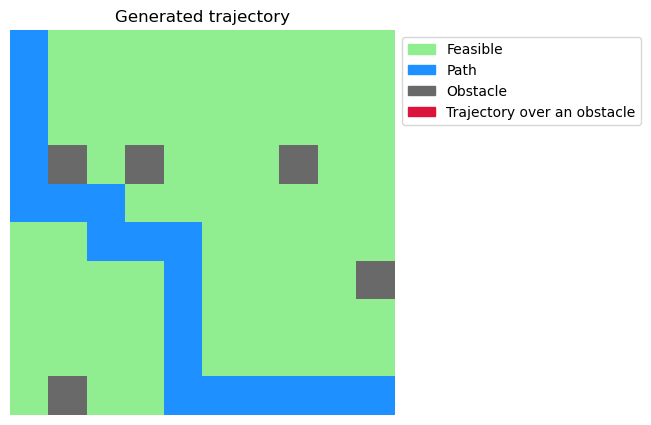

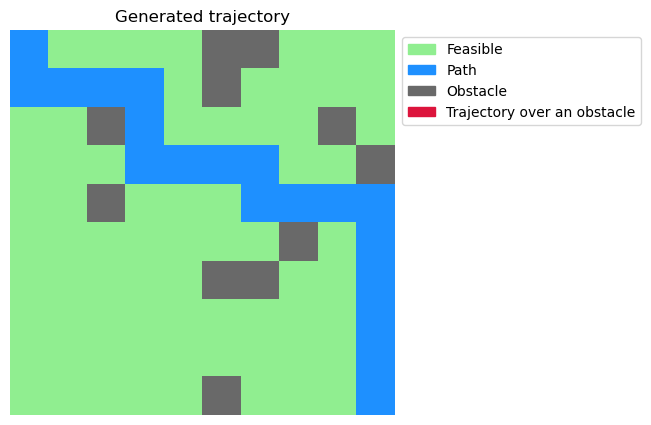

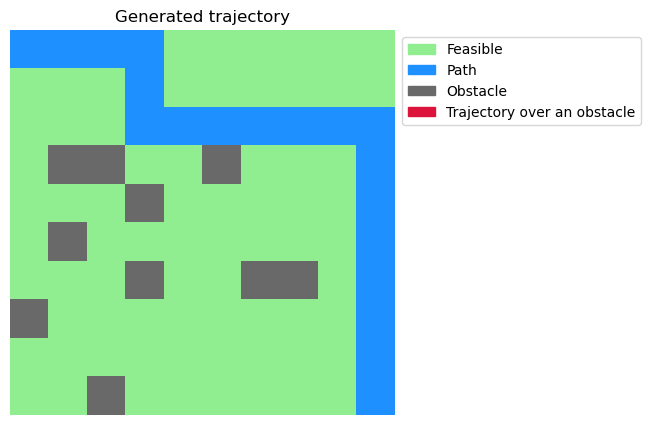

In [125]:
N = 3

for _ in range(N):
    idx = np.random.randint(0,1000) # 1000 is the legnth of the testing tuple
    map_holes = test_maps[idx,0,:,:]
    
    generated_traj, frames = sample(model, T, map_holes, DEVICE)
    generated_traj = generated_traj[0,0,:,:].cpu().detach().numpy()

    plot_array(generated_traj, map_holes)

Plotting the reverse diffusion process:

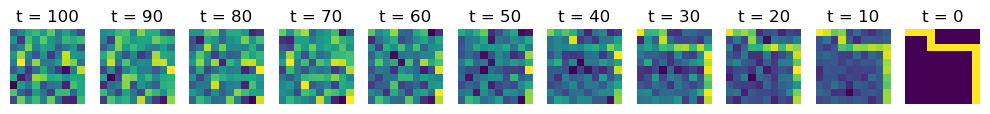

In [127]:
fig, axes = plt.subplots(1, len(frames), figsize = (10,10))
axes = axes.flatten()
tt = 100

for j, ax in enumerate(axes):
    ax.imshow(frames[j])
    ax.axis("off")  # Hide axis ticks and labels
    ax.set_title('t = {}'.format(tt))
    tt -= 10
        
plt.tight_layout()
plt.show()

Repeating the sampling for multiple hole maps and checking the success rate: 

Success rate = 79.0 %


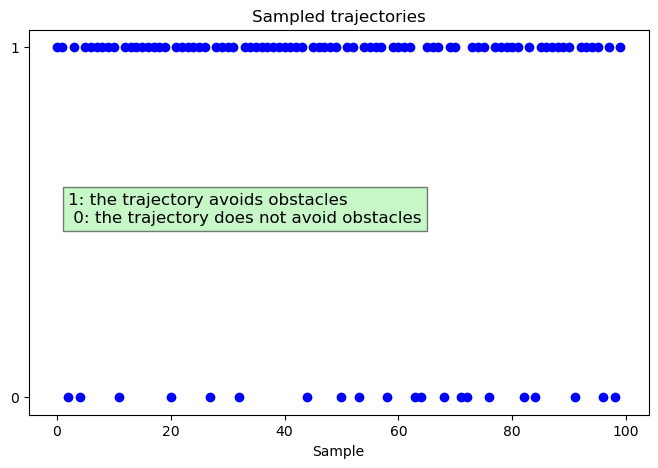

In [131]:
def check(traj, holes):
    if holes.ndim == 4:
        holes = holes[:,0,:,:]
    arr = traj + holes
    result = np.any(arr > 1.9, axis=(1, 2)).astype(int)
    return 1 - result

idx_list = np.random.randint(0,1000, (100,)) # 1000 is the legnth of the testing tuple
map_holes = test_maps[idx_list,:,:,:]

generated_traj, frames = sample(model, T, map_holes, DEVICE)
generated_traj = generated_traj[:,0,:,:].cpu().detach().numpy()
    
pippo = check(generated_traj, map_holes)

SR = (sum(pippo)/len(pippo))

print('Success rate = {} %'.format(SR*100))

# 1. Plot showing individual predictions (True/False)
plt.figure(figsize=(8, 5))
plt.plot(pippo, marker='o', linestyle='None', color='blue')
plt.title('Sampled trajectories')
plt.xlabel('Sample')
plt.text(2, 0.5, '1: the trajectory avoids obstacles \n 0: the trajectory does not avoid obstacles', 
         fontsize=12, bbox=dict(facecolor='lightgreen', alpha=0.5))
plt.yticks([0, 1])
plt.show()

The success rate should be approximately 75–85%. This indicates that the proposed diffusion model is not perfect, as in about 20% of cases it generates trajectories that lead the agent into a hole. However, since the diffusion model iteratively removes random noise step-by-step, resampling multiple times the trajectory may help avoid holes. To prevent infinite loops, the maximum number of iterations is limited to 10 times. Repeat more times the following block. 

Before repeating the sampling:


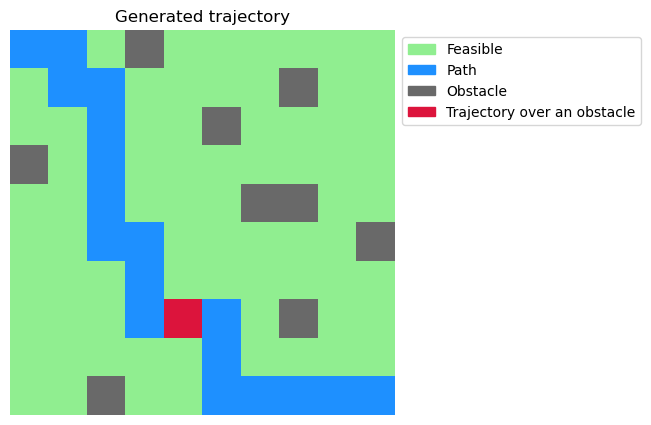

After repeating the sampling:


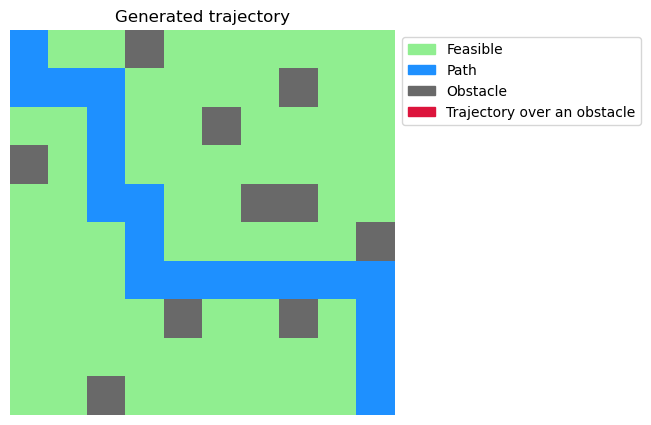

In [138]:
# Find the indices where the value is 0
zero_indices = np.where(pippo == 0)[0]
# Select a random index from the zero indices
idx = np.random.choice(zero_indices)

print('Before repeating the sampling:')
plot_array(generated_traj[idx,:,:], map_holes[idx,0,:,:])


holes = map_holes[idx,0,:,:]

done = False; k = 0
while not done:
    generated_traj_new, fr = sample(model, T, holes, DEVICE)
    generated_traj_new = generated_traj_new[0,0,:,:].cpu().detach().numpy()
    
    arr = generated_traj_new + holes
    done = not np.any(arr > 2.8).item()

    k += 1
    if k == 10:
        done = True

print('After repeating the sampling:')
plot_array(generated_traj_new, holes)

Even though it is not demonstrated here, resampling improves the success rate of the proposed method up to 90%. However, the drawback is that resampling consumes additional time. The Q-learning algorithm from the previous assignment achieved a nearly 100% success rate in the deterministic case but required a long learning phase each time the environment changed. The main advantage of the proposed diffusion model is its ability to instantly solve maps it has never encountered before. To conclude, a controller is implemented to control the agent in the gymansium environment: 

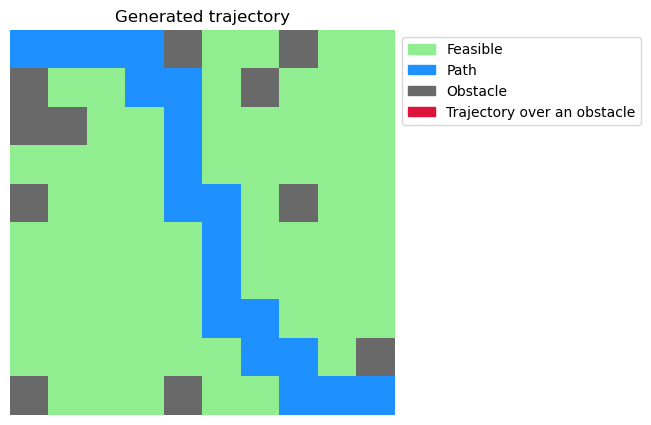

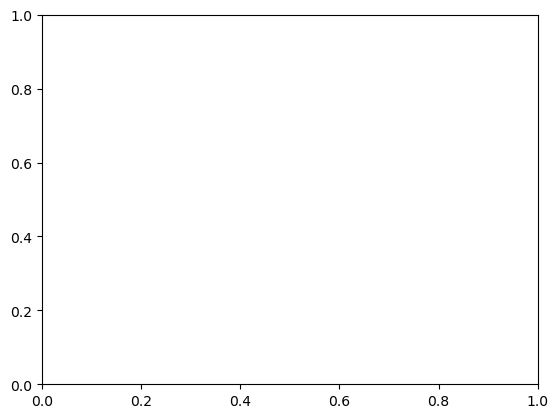

In [141]:
import gymnasium as gym 
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import matplotlib.animation as animation
import matplotlib.colors as mcolors

def generate_random_lake(size): 
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=False,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=size, p=0.9, seed = 100
        ),
    )  
    desc = env.unwrapped.desc  # Get map description
    grid_size = len(desc)
    arr = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            if desc[i][j] == b'H':  # Holes
                arr[i, j] = 1
    return arr, env

class Controller():
    def __init__(self, traj):
        self.traj = traj
        self.map_size = len(traj[:,0])

    def take_action(self, s):
        i = s // self.map_size
        j = s % self.map_size
        a = 0 # initialize the action
        if j < self.map_size-1:
            if abs(self.traj[i,j+1] - 1) < 0.1: 
                a = 2 # move right
        if j > 0:
            if abs(self.traj[i,j-1] - 1) < 0.1: 
                a = 0 # move left
        if i > 0:
            if abs(self.traj[i-1,j] - 1) < 0.1: 
                a = 3 # move up
        if i < self.map_size-1:
            if abs(self.traj[i+1,j] - 1) < 0.1: 
                a = 1 # move down
            
        self.traj[i,j] = 0.5

        return a

holes, env = generate_random_lake(10) 

done = False; k = 0
while not done:
    generated_traj_new, fr = sample(model, T, holes, DEVICE)
    generated_traj_new = generated_traj_new[0,0,:,:].cpu().detach().numpy()
    arr = generated_traj_new + holes
    done = not np.any(arr > 2.8).item()
    if k == 15:
        done = True

plot_array(generated_traj_new, holes)

s = env.reset()[0]
Done = False; frames = []
controller = Controller(generated_traj_new)

while not Done:
    action = controller.take_action(s)
    s, rewards, terminated, truncated, info = env.step(action)
    frames.append(env.render())
    Done = terminated or truncated

# Create animation
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.imshow(frames[frame])
    ax.axis("off")

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=250)
plt.show()
    

Sometimes the animation doesn't work in the Jupyter notebook, so the frames are plotted separately:

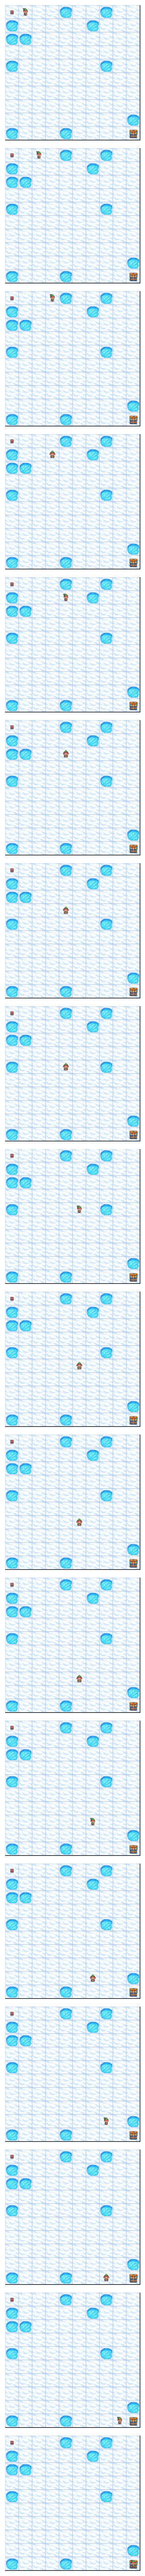

In [144]:
fig, axes = plt.subplots(len(frames),1, figsize = (5,50))
axes = axes.flatten()
tt = 100

for j, ax in enumerate(axes):
    ax.imshow(frames[j])
    ax.axis("off")  # Hide axis ticks and labels
        
plt.tight_layout()
plt.show()

Reference works:
[1] Liang, Jing, et al. "Dtg: Diffusion-based trajectory generation for mapless global navigation." 2024 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS). IEEE, 2024.

[2] Yu, Xinyao, et al. "Trajectory Diffusion for ObjectGoal Navigation." Advances in Neural Information Processing Systems 37 (2024)